In [1]:
import pandas as pd
import numpy as np
import json
import os
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
from sklearn.ensemble import RandomForestRegressor
import warnings

In [2]:
#pip install skforecast

In [3]:
path = os.getcwd()
path = path.replace("\\", "\\\\")
path = path.replace("\\\\", "/")
path_data = "/".join(path.split("/")[:-1]) + "/Data/"
path_est = path_data + "Estandarizada/"

## Por provincia

In [4]:
df = pd.read_csv(path_est + "data_refined.csv", keep_default_na=False, na_values="", sep=',')
df['FECHA'] = pd.to_datetime(df.FECHA).dt.to_period('m')

In [5]:
df = df[df['PROVINCIA'] == 'MADRID']
df = df.drop(columns=['PROVINCIA'])

In [6]:
df.shape

(38, 10)

In [7]:
df

,FECHA,ALTITUD,TEMP_MED,PREC,DIR,VEL_MEDIA,RACHA,PRES_MIN,SOL,TASA_INCIDENCIA
32,2020-01,609.0,6.622581,0.400000,32.225806,2.474194,8.609677,955.351613,4.193548,0.02
84,2020-02,609.0,9.817241,0.003448,52.103448,2.189655,7.410345,955.993103,5.644828,0.31
136,2020-03,609.0,11.132258,2.132258,47.677419,3.558065,10.351613,946.696774,5.248387,619.46
188,2020-04,609.0,13.910000,2.386667,38.166667,2.863333,9.810000,945.516667,5.090000,373.31
240,2020-05,609.0,19.454839,1.741935,41.000000,3.038710,10.329032,947.235484,9.309677,79.44
292,2020-06,609.0,22.433333,0.483333,46.966667,3.533333,11.353333,945.200000,11.103333,45.49
344,2020-07,609.0,28.177419,0.096774,37.354839,2.883871,10.706452,946.658065,12.077419,85.21
396,2020-08,609.0,25.419355,0.603226,32.483871,3.225806,11.170968,945.893548,10.761290,835.15
448,2020-09,609.0,20.626667,2.390000,40.266667,2.530000,10.460000,948.430000,8.170000,1722.55
500,2020-10,609.0,13.332258,1.283871,49.548387,3.116129,10.122581,948.119355,6.616129,1011.97


#Crear un objeto FeatureHasher
fh = FeatureHasher(n_features=6, input_type='string')
#Transformar la variable categórica utilizando la codificación Hashing
hashed = fh.transform(df['PROVINCIA'])
#Convertir el resultado en un dataframe
hashed_df = pd.DataFrame(hashed.toarray())
#Unir el dataframe original con el dataframe de características codificadas
df = pd.concat([df, hashed_df], axis=1)
df = df.drop(columns=['PROVINCIA'])

In [8]:
df['FECHA'] = df['FECHA'].astype(str)
df['FECHA'] = pd.to_datetime(df['FECHA'], format='%Y/%m/%d')
df = df.set_index('FECHA')
df = df.asfreq('MS')
df = df.sort_index()
df.head()

,ALTITUD,TEMP_MED,PREC,DIR,VEL_MEDIA,RACHA,PRES_MIN,SOL,TASA_INCIDENCIA
FECHA,,,,,,,,,
2020-01-01,609.0,6.622581,0.400000,32.225806,2.474194,8.609677,955.351613,4.193548,0.02
2020-02-01,609.0,9.817241,0.003448,52.103448,2.189655,7.410345,955.993103,5.644828,0.31
2020-03-01,609.0,11.132258,2.132258,47.677419,3.558065,10.351613,946.696774,5.248387,619.46
2020-04-01,609.0,13.910000,2.386667,38.166667,2.863333,9.810000,945.516667,5.090000,373.31
2020-05-01,609.0,19.454839,1.741935,41.000000,3.038710,10.329032,947.235484,9.309677,79.44


In [9]:
df.shape

(38, 9)

Fechas train : 2020-01-01 00:00:00 --- 2022-02-01 00:00:00  (n=26)
Fechas test  : 2022-03-01 00:00:00 --- 2023-02-01 00:00:00  (n=12)


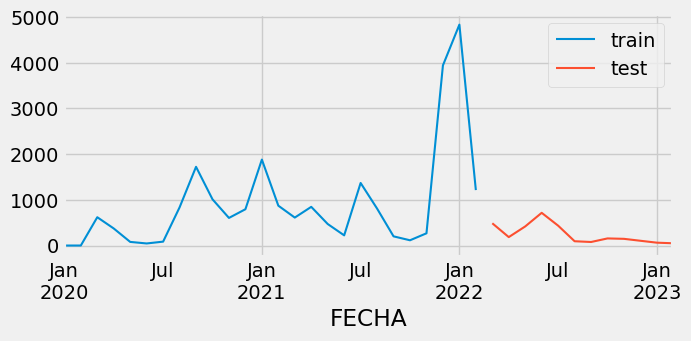

In [10]:
steps = 12
datos_train = df[:-steps]
datos_test  = df[-steps:]
print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(7, 3))
datos_train['TASA_INCIDENCIA'].plot(ax=ax, label='train')
datos_test['TASA_INCIDENCIA'].plot(ax=ax, label='test')
ax.legend();

In [11]:
# Crear y entrenar forecaster
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(n_estimators= 256, criterion='absolute_error',random_state=112),
                lags = 10
             )

forecaster.fit(y=datos_train['TASA_INCIDENCIA'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(criterion='absolute_error', n_estimators=256,
                      random_state=112) 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Transformer for y: None 
Transformer for exog: None 
Window size: 10 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2020-01-01 00:00:00'), Timestamp('2022-02-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 256, 'n_jobs': None, 'oob_score': False, 'random_state': 112, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-05-04 21:29:25 
Last fit date: 2023-05-04 21:29:25

In [12]:
steps = 12
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

2022-03-01     625.023984
2022-04-01     682.781328
2022-05-01    1016.774570
2022-06-01    1086.263633
2022-07-01     945.036055
Freq: MS, Name: pred, dtype: float64

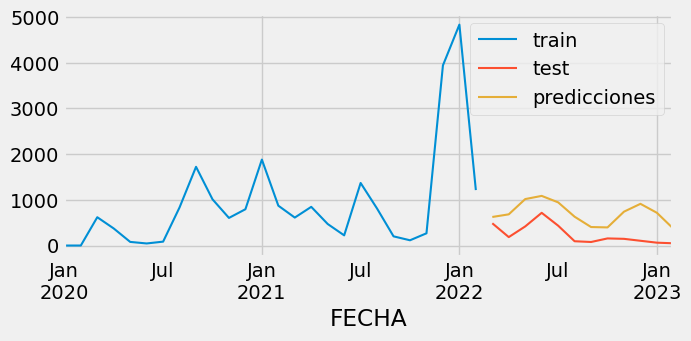

In [13]:
fig, ax = plt.subplots(figsize=(7, 3))
datos_train['TASA_INCIDENCIA'].plot(ax=ax, label='train')
datos_test['TASA_INCIDENCIA'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [14]:
mse = metrics.mean_squared_error(
                y_true = datos_test['TASA_INCIDENCIA'],
                y_pred = predicciones,
                squared = True
            )
rmse = metrics.mean_squared_error(
                y_true = datos_test['TASA_INCIDENCIA'],
                y_pred = predicciones,
                squared = False
            )
mae = metrics.mean_absolute_error(datos_test['TASA_INCIDENCIA'], predicciones)
r2 = metrics.r2_score(datos_test['TASA_INCIDENCIA'], predicciones)

print(f"El error (mse) de test : {mse}")
print("")
print(f"El error (rmse) de test es: {rmse}")
print("")
print(f"El error (mae) de test es: {mae}")
print("")
print(f"El error (r2) de test es: {r2}")

El error (mse) de test : 251066.1087566303

El error (rmse) de test es: 501.064974585762

El error (mae) de test es: 466.395865885416

El error (r2) de test es: -4.9092311739250025


In [15]:
impotancia = forecaster.get_feature_importance()
impotancia

,feature,importance
0,lag_1,0.064601
1,lag_2,0.113163
2,lag_3,0.398000
3,lag_4,0.047827
4,lag_5,0.027704
5,lag_6,0.040088
6,lag_7,0.053470
7,lag_8,0.109802
8,lag_9,0.101280
9,lag_10,0.044065


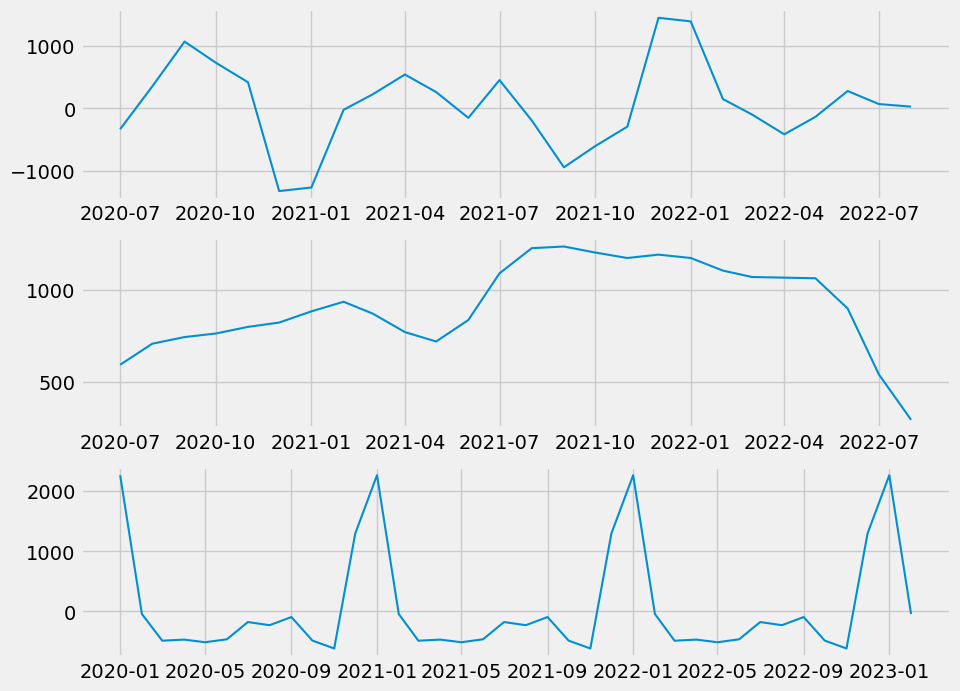

In [16]:
# Ejemplo de descomposición de serie de tiempo #resid, trend, seasonal
import statsmodels.api as sm
descomposicion = sm.tsa.seasonal_decompose(df['TASA_INCIDENCIA'], model='additive')
#plt.figure(figsize=(10,4))
#plt.plot(descomposicion.resid)
#fig = descomposicion.plot()
fig, axs = plt.subplots(3, figsize=(10,8))
axs[0].plot(descomposicion.resid)
#axs[0].set_title('resid')
axs[1].plot(descomposicion.trend)
#axs[1].set_title('trend')
axs[2].plot(descomposicion.seasonal)
#axs[2].set_title('seasonal')
plt.show()

## A nivel nacional

In [17]:
df = pd.read_csv(path_est + "data_refined.csv", keep_default_na=False, na_values="", sep=',')
df['FECHA'] = pd.to_datetime(df.FECHA).dt.to_period('m')

In [18]:
df = df.drop(columns=['PROVINCIA'])

df = df.groupby(['FECHA']).agg(
    {'ALTITUD': 'mean', 'TEMP_MED': 'mean', 
     'PREC': 'mean', 'DIR': 'mean', 'VEL_MEDIA': 'mean', 'RACHA': 'mean', 
     'PRES_MIN': 'mean', 'SOL': 'mean', 'TASA_INCIDENCIA': 'sum'}).reset_index()

df['FECHA'] = df['FECHA'].astype(str)
df['FECHA'] = pd.to_datetime(df['FECHA'], format='%Y/%m/%d')
df = df.set_index('FECHA')
df = df.asfreq('MS')
df = df.sort_index()
df.head()

,ALTITUD,TEMP_MED,PREC,DIR,VEL_MEDIA,RACHA,PRES_MIN,SOL,TASA_INCIDENCIA
FECHA,,,,,,,,,
2020-01-01,397.442308,8.564826,1.777357,33.622208,2.751179,8.826241,976.813524,4.654529,0.55
2020-02-01,397.442308,11.855902,0.336207,34.552387,2.693568,8.593634,977.143568,6.715782,8.01
2020-03-01,397.442308,11.846764,2.487370,30.794516,3.686973,11.223367,968.845610,6.129385,13212.19
2020-04-01,397.442308,14.385256,2.644744,31.166026,3.063333,9.666026,967.505833,5.525897,12414.21
2020-05-01,397.442308,18.882321,1.608123,31.373660,3.165427,9.780920,969.439752,9.010082,2717.24


In [19]:
df.shape

(38, 9)

Fechas train : 2020-01-01 00:00:00 --- 2022-02-01 00:00:00  (n=26)
Fechas test  : 2022-03-01 00:00:00 --- 2023-02-01 00:00:00  (n=12)


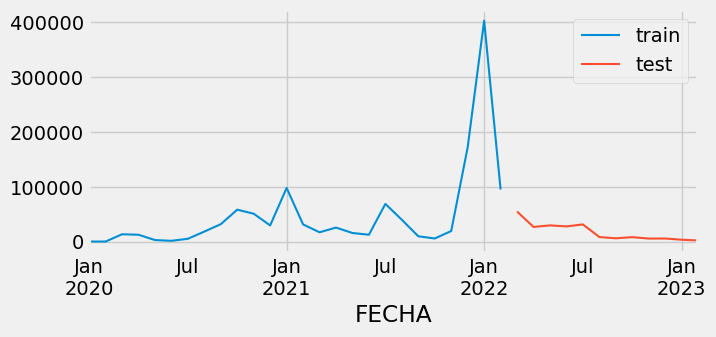

In [20]:
steps = 12
datos_train = df[:-steps]
datos_test  = df[-steps:]
print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(7, 3))
datos_train['TASA_INCIDENCIA'].plot(ax=ax, label='train')
datos_test['TASA_INCIDENCIA'].plot(ax=ax, label='test')
ax.legend();

In [21]:
# Crear y entrenar forecaster
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(n_estimators= 256, criterion='absolute_error', random_state=112),
                lags = 10
             )

forecaster.fit(y=datos_train['TASA_INCIDENCIA'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(criterion='absolute_error', n_estimators=256,
                      random_state=112) 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Transformer for y: None 
Transformer for exog: None 
Window size: 10 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2020-01-01 00:00:00'), Timestamp('2022-02-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 256, 'n_jobs': None, 'oob_score': False, 'random_state': 112, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-05-04 21:29:26 
Last fit date: 2023-05-04 21:29:27

In [22]:
steps = 12
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

2022-03-01    45185.025312
2022-04-01    37426.629648
2022-05-01    46332.614570
2022-06-01    77406.169023
2022-07-01    77776.566406
Freq: MS, Name: pred, dtype: float64

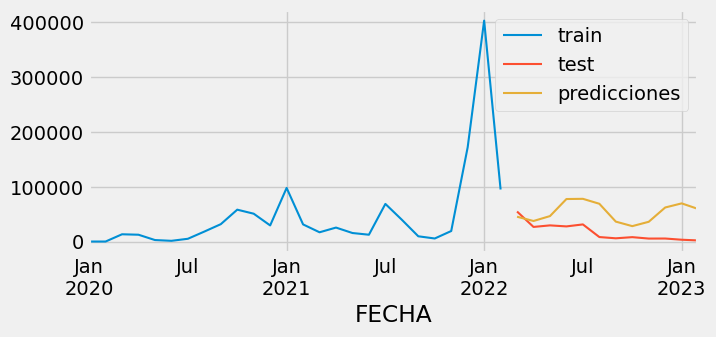

In [23]:
fig, ax = plt.subplots(figsize=(7, 3))
datos_train['TASA_INCIDENCIA'].plot(ax=ax, label='train')
datos_test['TASA_INCIDENCIA'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [24]:
mse = metrics.mean_squared_error(
                y_true = datos_test['TASA_INCIDENCIA'],
                y_pred = predicciones,
                squared = True
            )
rmse = metrics.mean_squared_error(
                y_true = datos_test['TASA_INCIDENCIA'],
                y_pred = predicciones,
                squared = False
            )
mae = metrics.mean_absolute_error(datos_test['TASA_INCIDENCIA'], predicciones)
r2 = metrics.r2_score(datos_test['TASA_INCIDENCIA'], predicciones)

print(f"El error (mse) de test : {mse}")
print("")
print(f"El error (rmse) de test es: {rmse}")
print("")
print(f"El error (mae) de test es: {mae}")
print("")
print(f"El error (r2) de test es: {r2}")

El error (mse) de test : 1828119803.7229357

El error (rmse) de test es: 42756.517675354895

El error (mae) de test es: 37937.62586263022

El error (r2) de test es: -6.4677062567277765


In [25]:
impotancia = forecaster.get_feature_importance()
impotancia

,feature,importance
0,lag_1,0.097890
1,lag_2,0.092794
2,lag_3,0.377607
3,lag_4,0.069648
4,lag_5,0.047422
5,lag_6,0.113457
6,lag_7,0.077389
7,lag_8,0.059880
8,lag_9,0.031993
9,lag_10,0.031921


In [37]:
impotancia[['importance']]

,importance
0,0.097890
1,0.092794
2,0.377607
3,0.069648
4,0.047422
5,0.113457
6,0.077389
7,0.059880
8,0.031993
9,0.031921


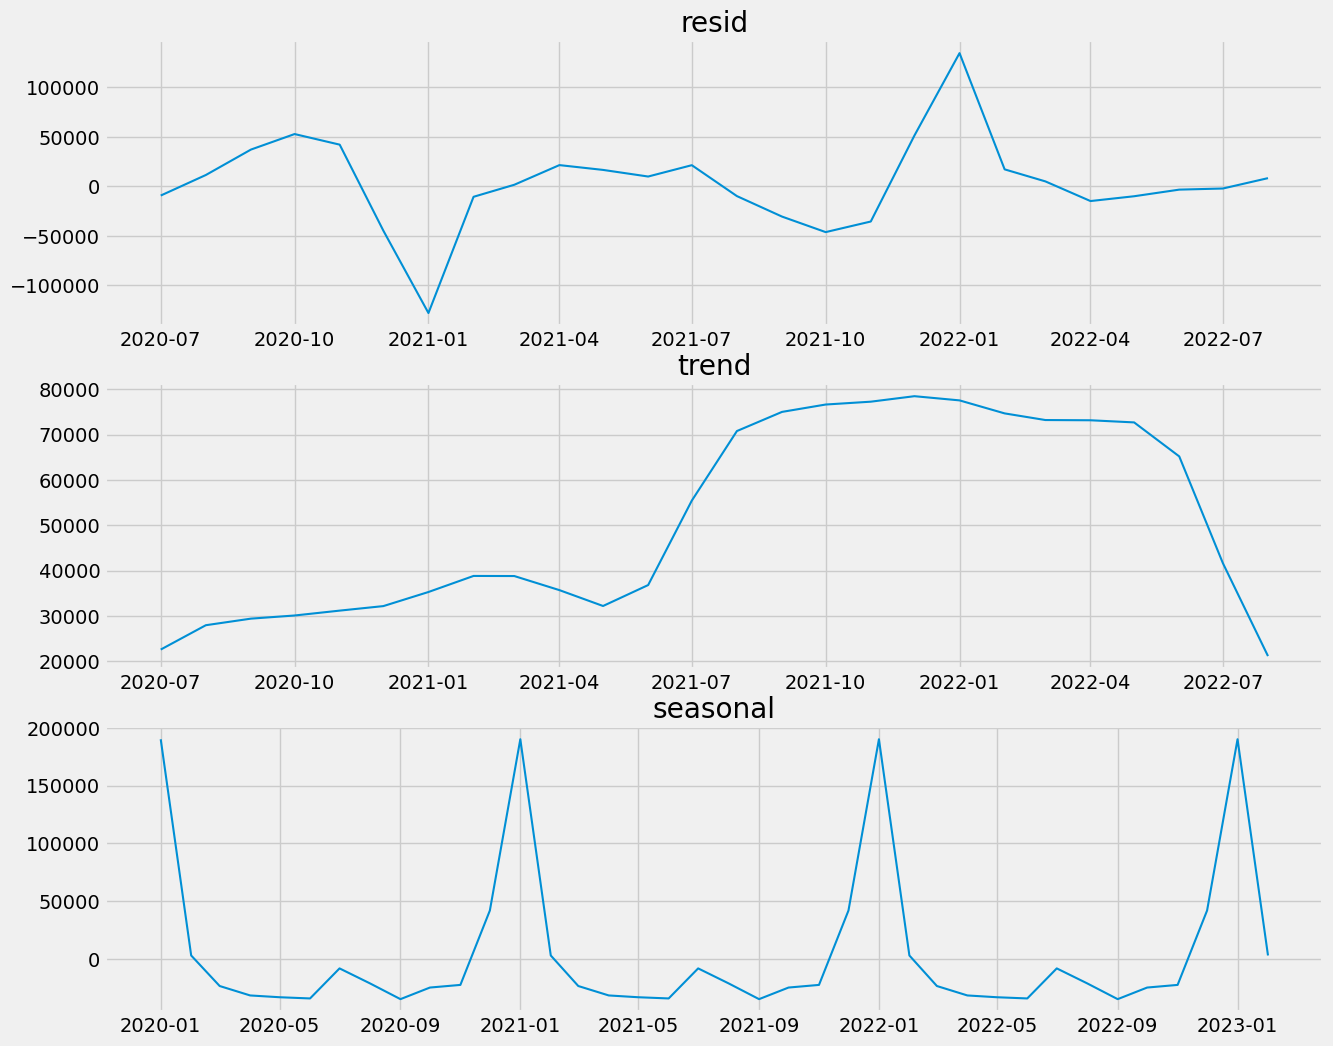

In [39]:
# Ejemplo de descomposición de serie de tiempo #resid, trend, seasonal
import statsmodels.api as sm
descomposicion = sm.tsa.seasonal_decompose(df['TASA_INCIDENCIA'], model='additive')
#plt.figure(figsize=(10,4))
#plt.plot(descomposicion.resid)
#fig = descomposicion.plot()
fig, axs = plt.subplots(3, figsize=(14,12))
axs[0].plot(descomposicion.resid)
axs[0].set_title('resid')
axs[1].plot(descomposicion.trend)
axs[1].set_title('trend')
axs[2].plot(descomposicion.seasonal)
axs[2].set_title('seasonal')
plt.show()

# Fin